In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import os
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from resnet import ResNet18, ResNet50, ResNet101
from CustomDataLoader import CustomImageDataset_from_csv

PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


ModuleNotFoundError: No module named 'CustomDataLoader'

In [ ]:
print("The current DIR: ", os.getcwd())
np.random.seed(1000)
torch.manual_seed(1000)

In [ ]:
def get_GPU_info():
    print(torch.cuda.max_memory_allocated())
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary()) 

    available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
    print(available_gpus)

    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())
#     print(torch.cuda.mem_get_info(device=device))
    return

In [ ]:
get_GPU_info()
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
print("DEVICE currently being used: ", device)

In [ ]:
model = TempModel()
model.load_state_dict(torch.load(file_path))
model.eval()

In [16]:
from torchvision.models import resnet18, resnet50

OUTPUT_DIR = Path('/home/shsingh/knowledge_distillation/outputs')
teacher_model_path = OUTPUT_DIR / "t1" / 'exp_01/resnet50_base_no_weights/resnet50_base.pt'

teacher = resnet50(weights=None)
n_inputs = teacher.fc.in_features
teacher.fc = nn.Sequential(
    nn.Linear(n_inputs, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(64, 3),
)
teacher.load_state_dict(torch.load(teacher_model_path))

<All keys matched successfully>

In [17]:
with torch.no_grad():
    teacher.eval()

In [24]:
from pathlib import Path
OUTPUT_DIR = Path('/home/shsingh/knowledge_distillation/outputs')


def get_resnet50_model(num_classes, device_index):
    device = torch.device(device_index) if torch.cuda.is_available() else torch.device('cpu')
    np.random.seed(31101995)
    torch.manual_seed(31101995)
    model = resnet50(weights=None)
    # model = resnet50(weights=to_use_pre_trained_weights)
    # model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.4),
        nn.Linear(64, num_classes),
    )
    return model


def get_teacher_student_model(num_classes, device_index, mod):
    device = torch.device(device_index) if torch.cuda.is_available() else torch.device('cpu')
    #get pre-trained teacher model
    teaccher = get_resnet50_model(num_classes, device) 
    #TODO: Intialize model and load checkpoint instead of savinng model as ".pt"
    teacher_model_path = OUTPUT_DIR / mod / 'exp_01/resnet50_base_no_weights/resnet50_base.pt'
#     teacher = torch.load(teacher_model_path) 
    teacher.load_state_dict(torch.load(teacher_model_path))
    #initialize student model
#     student = get_resnet18_model(num_classes, device_index, to_use_pre_trained_weights)
    return  teacher

# , student.to(device)

In [25]:
teacher = get_teacher_student_model(3, 7, "t1")

In [26]:
with torch.no_grad():
    teacher.eval()

In [12]:
for param_tensor in teacher.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

# Data preprocessing

In [5]:
csv_path = 'knowledge_distillation/dataset/scratch/mapping.csv'

image_path = 'knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData_2D/'
image_size = 240
num_classes = 3

batch_size = 64

classes =['healthy', 'HGG', 'LGG']

In [6]:
def get_data_csv(csv_path):
    
    
    df = pd.read_csv(csv_path, delimiter ='\t')
    del df['Unnamed: 0']
    df = df[df.label != 'discard']
    print(df.head)
        
    training_df, test_df = train_test_split(df ,test_size = 0.12, random_state = 42, shuffle = True)
    train_df , val_df = train_test_split(training_df,test_size = 0.2, random_state = 42, shuffle = True)
    
    
    
    print(train_df['label'].value_counts())
    print("Trainig data: Class distribution")
    train_df['label'].value_counts().plot.bar(x='lab', y='#samples', rot=0)

 
    print(val_df['label'].value_counts())
    print("Validation data: Class distribution")
    val_df['label'].value_counts().plot.bar(x='lab', y='#samples', rot=0)
    
    print(test_df['label'].value_counts())
    print("Test data: Class distribution")
    test_df['label'].value_counts().plot.bar(x='lab', y='#samples', rot=0)
       
    return train_df, val_df, test_df

<bound method NDFrame.head of       BraTS_2020_subject_ID                          image_name    label
1      BraTS20_Training_030   BraTS20_Training_030_flair_39.png  healthy
2      BraTS20_Training_030  BraTS20_Training_030_flair_134.png  healthy
3      BraTS20_Training_030   BraTS20_Training_030_flair_45.png  healthy
4      BraTS20_Training_030   BraTS20_Training_030_flair_94.png      HGG
5      BraTS20_Training_030  BraTS20_Training_030_flair_133.png  healthy
...                     ...                                 ...      ...
57190  BraTS20_Training_170   BraTS20_Training_170_flair_68.png      HGG
57191  BraTS20_Training_170  BraTS20_Training_170_flair_111.png  healthy
57192  BraTS20_Training_170   BraTS20_Training_170_flair_66.png      HGG
57193  BraTS20_Training_170   BraTS20_Training_170_flair_61.png      HGG
57194  BraTS20_Training_170  BraTS20_Training_170_flair_116.png  healthy

[50692 rows x 3 columns]>
healthy    26489
HGG         8186
LGG         1011
Name: label, dty

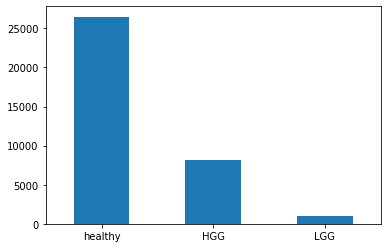

In [7]:
train_df, val_df, test_df = get_data_csv(csv_path)

In [8]:


# train_data = CustomImageDataset_from_csv(train_df , image_path)
# val_data = CustomImageDataset_from_csv(val_df , image_path)
# test_data = CustomImageDataset_from_csv(test_df , image_path)

In [9]:
train_data = CustomImageDataset_from_csv(train_df , image_path,
           transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                    transforms.Normalize((0.5, ), (0.5, ))
                               ]))

val_data = CustomImageDataset_from_csv(val_df , image_path,
         transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                     transforms.Normalize((0.5, ), (0.5, ))
                               ]))


test_data = CustomImageDataset_from_csv(test_df , image_path,
          transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                     transforms.Normalize((0.5, ), (0.5, ))                              
                               ]))

In [10]:
    
print("Shape of trainig data :",train_data.img_labels.shape)
print("Shape of validation data :",val_data.img_labels.shape)
print("Shape of test data :",test_data.img_labels.shape)

Shape of trainig data : (35686, 3)
Shape of validation data : (8922, 3)
Shape of test data : (6084, 3)


In [11]:


train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

torch.Size([64, 1, 240, 240])


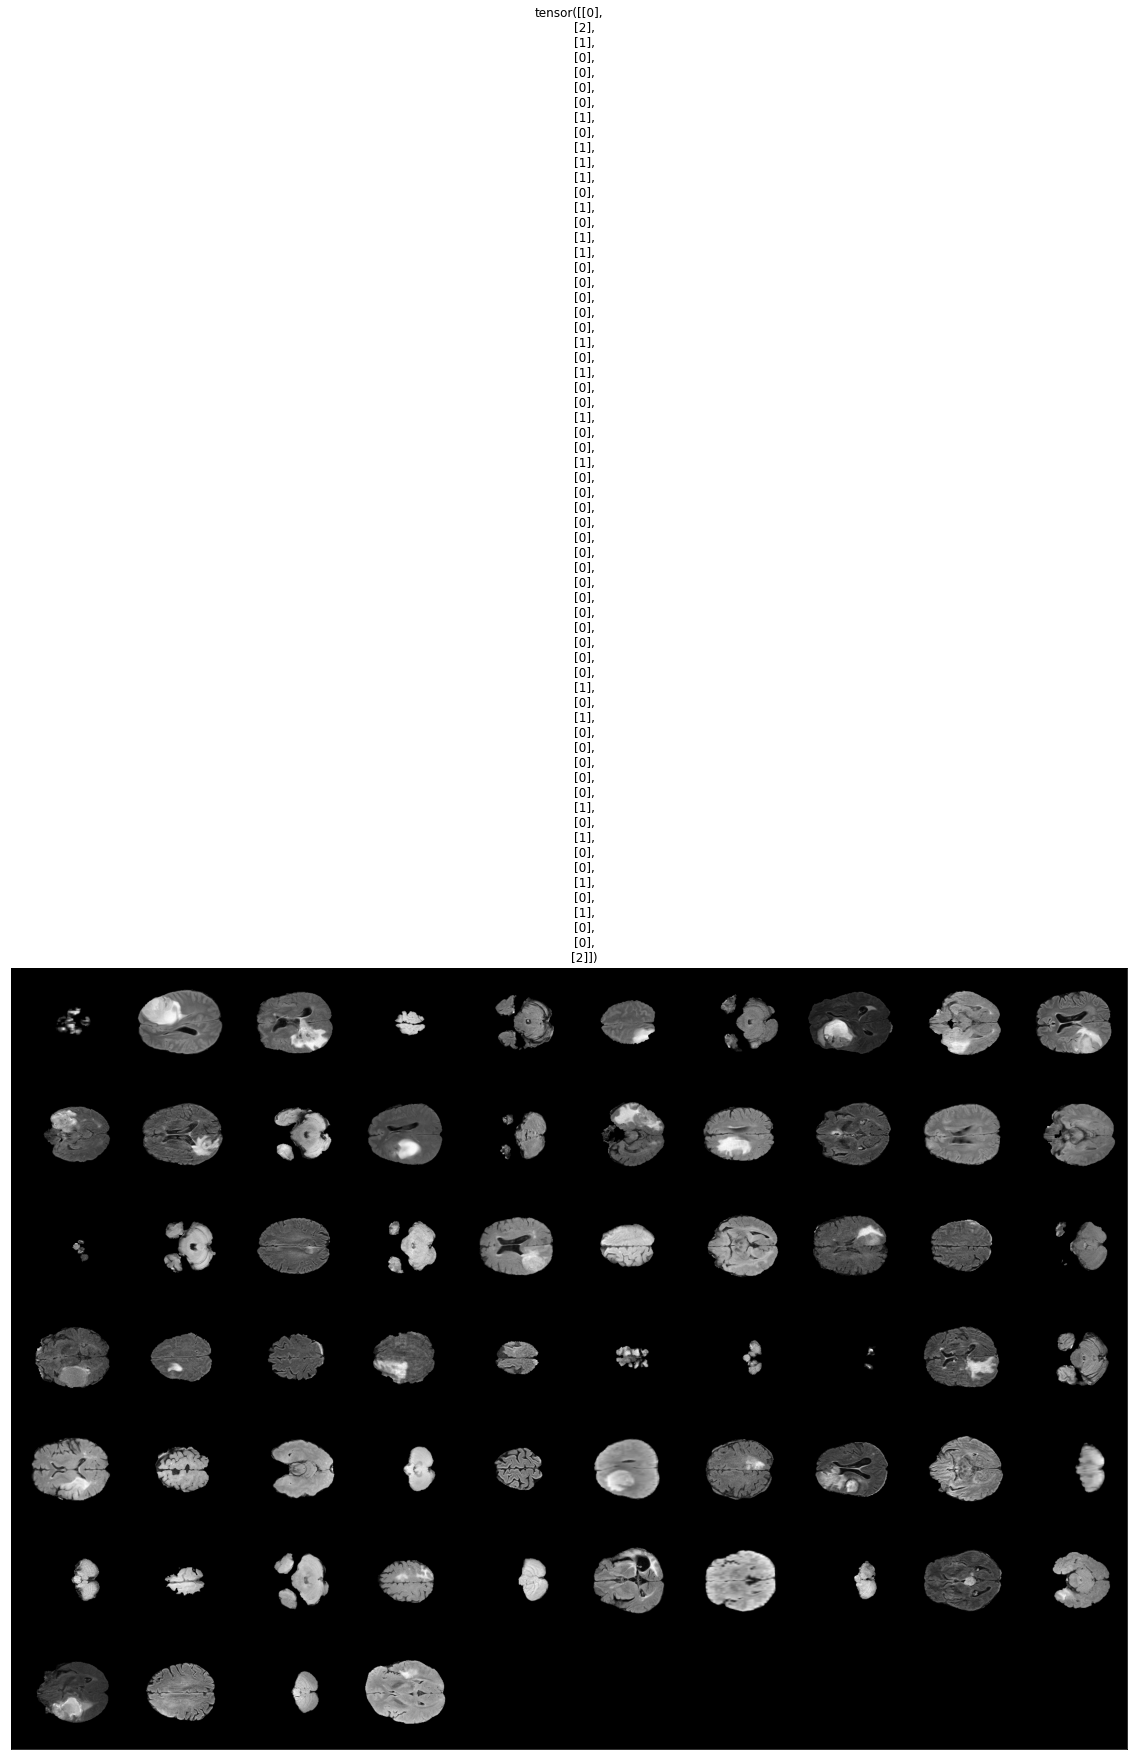

In [12]:

for images, labels in train_dataloader:
    

    fig, ax = plt.subplots(figsize = (20, 20))
    print(np.shape(images))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    ax.set_title((labels))
    break
        
    
    
# print(np.shape(labels[0]))

In [ ]:
diplay_training_samples()

# Knowledge Distillation: Teacher-Student Model

In [12]:
from resnet import ResNet18, ResNet50, ResNet101
# model = ResNet18()
model = ResNet18()
model.fc = nn.Sequential(
            nn.Linear(2048, 3, bias = True),
            )
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [13]:
teacher = ResNet50()

teacher.fc = nn.Sequential(
            nn.Linear(2048, 3, bias = True),
            )
teacher.load_state_dict(torch.load('models/resnet50_base_model_25ep.pt'))
print(teacher)

teacher.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [18]:
# teacher = torch.load('knowledge_distillation/models/resnet50_base_model_25ep.pt')
# student =  torch.load('')


n_epochs = 35
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)


def loss_fn_kd(stud_labels, teacher_outputs ):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """
    alpha = 0.9
    T = 3
    KD_loss = nn.KLDivLoss()(F.log_softmax(stud_labels/T, dim=1), F.softmax(teacher_outputs/T, dim=1))
    
#     KD_loss = nn.KLDivLoss()(F.log_softmax(stud_labels/T, dim=1),
#                              F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) 

    return KD_loss

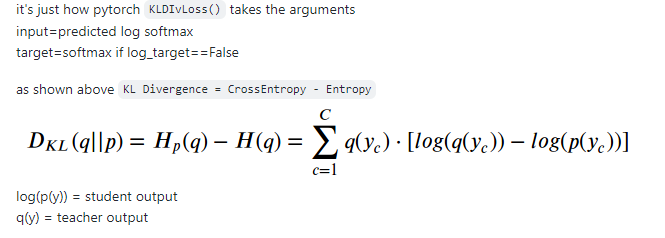

In [19]:
train_acc, val_acc,train_loss, val_loss=    train_kd_offline(teacher, model, n_epochs, train_dataloader,val_dataloader,  device,  optimizer)

Epoch 1



/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch [1/35], Step [0/558], Loss: 1.0715
Epoch [1/35], Step [50/558], Loss: 0.4126
Epoch [1/35], Step [100/558], Loss: 0.4485
Epoch [1/35], Step [150/558], Loss: 0.3987
Epoch [1/35], Step [200/558], Loss: 0.4409
Epoch [1/35], Step [250/558], Loss: 0.2184
Epoch [1/35], Step [300/558], Loss: 0.2754
Epoch [1/35], Step [350/558], Loss: 0.2408
Epoch [1/35], Step [400/558], Loss: 0.2915
Epoch [1/35], Step [450/558], Loss: 0.3285
Epoch [1/35], Step [500/558], Loss: 0.5595
Epoch [1/35], Step [550/558], Loss: 0.2448

train-loss: 0.3651, train-acc: 83.5201
validation loss: 0.3099, validation acc: 87.7270

Improvement-Detected, save-model
Epoch 2

Epoch [2/35], Step [0/558], Loss: 0.1969
Epoch [2/35], Step [50/558], Loss: 0.2050
Epoch [2/35], Step [100/558], Loss: 0.1830
Epoch [2/35], Step [150/558], Loss: 0.1643
Epoch [2/35], Step [200/558], Loss: 0.2098
Epoch [2/35], Step [250/558], Loss: 0.2336
Epoch [2/35], Step [300/558], Loss: 0.3216
Epoch [2/35], Step [350/558], Loss: 0.1882
Epoch [2/35], 

validation loss: 0.1782, validation acc: 95.2589

Epoch 14

Epoch [14/35], Step [0/558], Loss: 0.0049
Epoch [14/35], Step [50/558], Loss: 0.0136
Epoch [14/35], Step [100/558], Loss: 0.0153
Epoch [14/35], Step [150/558], Loss: 0.0052
Epoch [14/35], Step [200/558], Loss: 0.0054
Epoch [14/35], Step [250/558], Loss: 0.0037
Epoch [14/35], Step [300/558], Loss: 0.0040
Epoch [14/35], Step [350/558], Loss: 0.0048
Epoch [14/35], Step [400/558], Loss: 0.0618
Epoch [14/35], Step [450/558], Loss: 0.0524
Epoch [14/35], Step [500/558], Loss: 0.0510
Epoch [14/35], Step [550/558], Loss: 0.0029

train-loss: 0.0875, train-acc: 99.2490
validation loss: 0.1747, validation acc: 96.5142

Epoch 15

Epoch [15/35], Step [0/558], Loss: 0.0596
Epoch [15/35], Step [50/558], Loss: 0.0076
Epoch [15/35], Step [100/558], Loss: 0.0086
Epoch [15/35], Step [150/558], Loss: 0.0211
Epoch [15/35], Step [200/558], Loss: 0.0064
Epoch [15/35], Step [250/558], Loss: 0.0048
Epoch [15/35], Step [300/558], Loss: 0.0366
Epoch [15/

Epoch [27/35], Step [0/558], Loss: 0.0067
Epoch [27/35], Step [50/558], Loss: 0.0065
Epoch [27/35], Step [100/558], Loss: 0.0058
Epoch [27/35], Step [150/558], Loss: 0.0073
Epoch [27/35], Step [200/558], Loss: 0.0048
Epoch [27/35], Step [250/558], Loss: 0.0140
Epoch [27/35], Step [300/558], Loss: 0.0078
Epoch [27/35], Step [350/558], Loss: 0.0076
Epoch [27/35], Step [400/558], Loss: 0.0087
Epoch [27/35], Step [450/558], Loss: 0.0044
Epoch [27/35], Step [500/558], Loss: 0.0085
Epoch [27/35], Step [550/558], Loss: 0.0198

train-loss: 0.0551, train-acc: 99.4199
validation loss: 0.1564, validation acc: 96.5815

Epoch 28

Epoch [28/35], Step [0/558], Loss: 0.0023
Epoch [28/35], Step [50/558], Loss: 0.0069
Epoch [28/35], Step [100/558], Loss: 0.0040
Epoch [28/35], Step [150/558], Loss: 0.0342
Epoch [28/35], Step [200/558], Loss: 0.0057
Epoch [28/35], Step [250/558], Loss: 0.0124
Epoch [28/35], Step [300/558], Loss: 0.0038
Epoch [28/35], Step [350/558], Loss: 0.0085
Epoch [28/35], Step [400/5

In [16]:
def train_kd_offline(teacher, model, n_epochs, train_dataloader,val_dataloader,  device,  optimizer):
    
    
    print_every = 5
    
    alpha = 0.9
    
    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    
    criterion = nn.CrossEntropyLoss()
    
    total_step = len(train_dataloader)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
    
            
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            data_, target_= data_.to(device), target_.to(torch.int64)
            target_ = target_.squeeze_().to(device)
            optimizer.zero_grad()

            #OFFLINE_TRAINING: Getting soft labels from the Teacher model
            teacher.eval()
            with torch.no_grad():
                teach_labels = teacher(data_)    
                
            teach_labels = teach_labels.to(torch.float32)

            outputs = model(data_)                
            outputs = outputs.to(torch.float32)   

            #Calculating the loss between soft_labels(teacher) and the student preds
            kd_loss = loss_fn_kd(outputs, teach_labels)
            classfication_loss = criterion(outputs, target_)
            
            

            loss = alpha* classfication_loss + (1-alpha) * kd_loss  

    #         print("outs: ",np.shape(outputs))
    #         print("Targets: ",np.shape(target_))

            #Calculating the loss between soft_labels(teacher) and the student preds
          
    #         print("LOSS: ",loss)
            loss.backward()
            optimizer.step()
#             if lr_scheduler is not None:
#                 lr_scheduler.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for data_t, target_t in (val_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(torch.int64)

                target_t = target_t.squeeze_().to(device)


                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(val_dataloader))
            
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


            if network_learned:
                valid_loss_min = batch_loss
    #             torch.save(model.state_dict(), 'models/resnet50_base_model_25ep.pt')
                torch.save({'epoch': n_epochs,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
#                         'lr': lr_scheduler.state_dict(),
                        'loss': loss }
                       ,'models/resnet18_student_model_35ep.pt')
                        
                print('Improvement-Detected, save-model')
        model.train()
        
        
    return  train_acc, val_acc,train_loss, val_loss   




In [20]:

def plot_training_cruves(train_acc, val_acc,train_loss, val_loss ):
    
    fig = plt.figure(figsize=(10,5))
    plt.title("Train-Validation Accuracy")
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')


    fig = plt.figure(figsize=(10,5))
    plt.title("Train-Validation Loss")
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    
    return

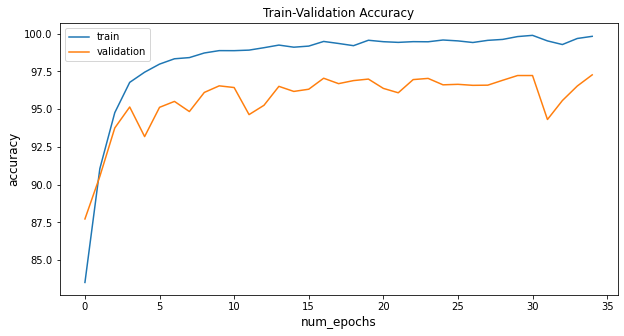

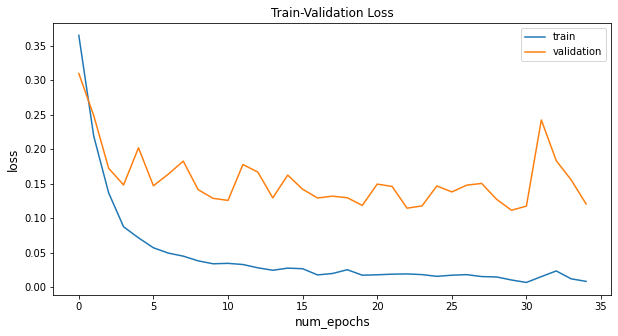

In [21]:
plot_training_cruves(train_acc, val_acc,train_loss, val_loss )

In [ ]:
def evaluate_test(test_dataloader, model):
    
     with torch.no_grad():
            model.eval()
    
    

In [39]:
correct = 0
total = 0

model.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.squeeze_().to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct += torch.sum(predicted==labels).item()
        total += labels.size(0)
        
print("Correctly classified samples: ",correct)        
print("Tital #samples: ", total)

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Correctly classified samples:  5882
Tital #samples:  6084
Accuracy of the network on the test images: 96.67981591058515 %


In [23]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

model.eval()
# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: healthy is 98.1 %
Accuracy for class: HGG   is 93.1 %
Accuracy for class: LGG   is 86.7 %


In [24]:
from sklearn.metrics import classification_report

In [25]:
import tqdm

import seaborn as sns

def get_confusion_matrix(model, dataloader):
        
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_test_pred = model(x_batch)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            
            
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
   
    
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    
    print("Pred: ",len(y_pred_list))
    print("True: ",len(y_true_list))
    
    print(classification_report(y_true_list, y_pred_list))
    print(confusion_matrix(y_true_list, y_pred_list))

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))
    # .rename(columns=idx2class, index=idx2class)
    fig, ax = plt.subplots(figsize=(7,5))         
    sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

Pred:  140
True:  140
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00         5

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

[[97  0  0]
 [ 0 38  0]
 [ 0  0  5]]


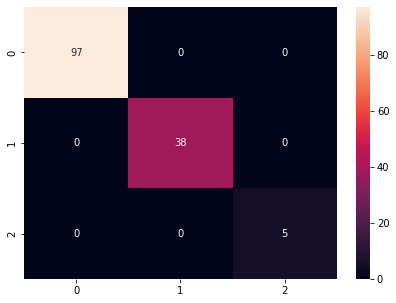

In [26]:
get_confusion_matrix(model, val_dataloader)

Pred:  96
True:  96
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        72
           1       0.84      1.00      0.91        21
           2       1.00      1.00      1.00         3

    accuracy                           0.96        96
   macro avg       0.95      0.98      0.96        96
weighted avg       0.96      0.96      0.96        96

[[68  4  0]
 [ 0 21  0]
 [ 0  0  3]]


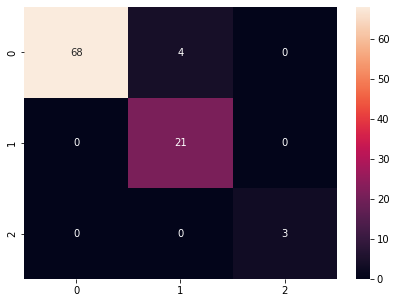

In [27]:
get_confusion_matrix(model, test_dataloader)

In [ ]:
for images, labels in train_dataloader:
    

    fig, ax = plt.subplots(figsize = (20, 20))
    print(np.shape(images))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    ax.set_title((labels))
    break
        

In [29]:
def img_display(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [ ]:
  for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


In [36]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

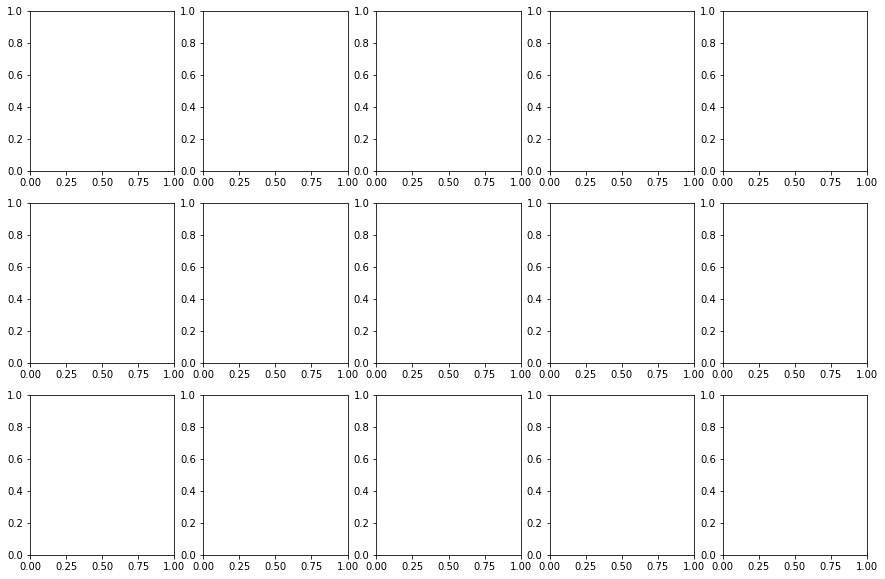

In [38]:

classes = {0: 'healthy', 1: 'HGG', 2: 'LGG'}

for test_img, test_labels in test_dataloader: 
    
    test_img.to(device)
    test_labels.to(device)
    # Viewing data examples used for training
    fig, axis = plt.subplots(3, 5, figsize=(15, 10))
    with torch.no_grad():
        model.eval()    
        for ax, image, label in zip(axis.flat,test_img, test_labels):            
             # add image

#             image_tensor = image.unsqueeze_(0)
            output_ = model(image)
            output_ = output_.argmax()
            k = output_.item()==label.item()
            ax.imshow(img_display(image))
            ax.set_title(str(classes[label.item()])+":" +str(k)) # add label


In [ ]:
def train_kd_online():
    n_epochs = 30
    print_every = 5

    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []

    

    total_step = len(train_dataloader)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            data_, target_= data_.to(device), target_.to(torch.int64)
            target_ = target_.squeeze_().to(device)
            
            optimizer.zero_grad()

            #ONLINE_TRAINING: Getting soft labels from the Teacher model
            teacher.eval()
            teach_labels = teacher(data_)    
            teach_labels = teach_labels.to(torch.float32)

            stud_labels = student(data_)                
            stud_labels.to(torch.float32)   

            #Calculating the loss between soft_labels(teacher) and the student preds
            distilltion_loss = criterion(stud_labels, teach_labels)
            classfication_loss = criterion(stud_labels, target_)
            
            
            loss = classfication_loss + distilltion_loss
            
    #         print("LOSS: ",loss)
            loss.backward()
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for data_t, target_t in (val_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(torch.int64)

                target_t = target_t.squeeze_().to(device)


                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


            if network_learned:
                valid_loss_min = batch_loss
    #             torch.save(model.state_dict(), 'models/resnet50_base_model_25ep.pt')
                print('Improvement-Detected, save-model')
        
        student.train()
